## Baseline w Normalization

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold, filter_by_label, merge_overlapping_detections
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


## Train Models

### Mean 0, Std 1.0


In [3]:
main_folder = r'E:\baseline-w-normalization'
spectro_file = main_folder + '\\' + 'spec_config_100-1200Hz-0.032-hamm-normalized0.json'
recipe_file = r'E:\final-baseline-detector\resnet_recipe-1.json'
pos_folder = r'E:\final-baseline-detector\annots\pos'
neg_folder = r'E:\final-baseline-detector\annots\neg'
file_durations_file = r'E:\final-baseline-detector\all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

db_name = main_folder + '\\' + 'final-baseline-db-normalized0.h5'
model_name = main_folder + '\\' + 'final-baseline-model-normalized0.kt'
temp_folder = main_folder + '\\' + 'rs-temp'

data_folder = r'D:\ringed-seal-data'

In [4]:
# Get list of all csv files in positives annot folder 
files_pos = glob.glob(pos_folder + "/*.csv")

site_names = []
num_annots = []

# For each csv file
for file in files_pos:

    annots = pd.read_csv(file)

    site_name = file.split('\\')[-1].split('.')[0].split('_')[0]

    site_names.append(site_name)
    num_annots.append(len(annots))

ULU22_val = num_annots[site_names.index('ULU2022')]
other_val = sum(num_annots) - ULU22_val
all_annots = sum(num_annots)

ulu_2022_split = 0.32
all_else_split = 1 - ulu_2022_split

dataset_split = [0.7, 0.2, 0.1]

train_annots = round(all_annots*dataset_split[0])
val_annots = round(all_annots*dataset_split[1])
test_annots = round(all_annots*dataset_split[2])

# ulu22 vals
ulu22_tr = round(train_annots*ulu_2022_split)
ulu22_va = round(val_annots*ulu_2022_split)
ulu22_te = round(test_annots*ulu_2022_split)

ulu22_leftovers = ULU22_val - ulu22_tr - ulu22_va - ulu22_te

if ulu22_leftovers < 0:
    ulu22_te = ulu22_te + ulu22_leftovers

if ulu22_leftovers > 0 :
    ulu22_tr = ulu22_tr + ulu22_leftovers

all_ulu = ulu22_tr + ulu22_te + ulu22_va

if all_ulu != ULU22_val:
    print('Something went wrong with Ulu')
    exit()

ulu2022_vals = [ulu22_tr, ulu22_va, ulu22_te]

# rest vals
rest_tr = round(train_annots*all_else_split)
rest_va = round(val_annots*all_else_split)
rest_te = round(test_annots*all_else_split)

# totals
all_added = rest_tr + rest_va + rest_te

if all_added < other_val:
    leftover = other_val - all_added
    rest_tr = rest_tr + leftover

if all_added > other_val:
    leftover = all_added - other_val
    rest_va = rest_va - leftover

all_added2 = rest_tr + rest_va + rest_te

cb_perc = num_annots[0]/all_added2
kk_perc = num_annots[1]/all_added2
ulu_perc = num_annots[4]/all_added2

# split into other site vals
cb_tr = round(cb_perc*rest_tr)
cb_va = round(cb_perc*rest_va)
cb_te = round(cb_perc*rest_te)
total_cb = cb_tr + cb_va + cb_te
if total_cb < num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_tr = cb_tr + leftover_cb
if total_cb > num_annots[0]:
    leftover_cb = num_annots[0] - total_cb
    cb_va = cb_va + leftover_cb
cb_vals = [cb_tr, cb_va, cb_te]

kk_tr = round(kk_perc*rest_tr)
kk_va = round(kk_perc*rest_va)
kk_te = round(kk_perc*rest_te)
total_kk = kk_tr + kk_va + kk_te
if total_kk < num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_tr = kk_tr + leftover_kk
if total_kk > num_annots[1]:
    leftover_kk = num_annots[1] - total_kk
    kk_va = kk_va + leftover_kk
kk_vals = [kk_tr, kk_va, kk_te]
    
ulu_tr = round(ulu_perc*rest_tr)
ulu_va = round(ulu_perc*rest_va)
ulu_te = round(ulu_perc*rest_te)
total_ulu = ulu_tr + ulu_va + ulu_te
if total_ulu < num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_tr = ulu_tr + leftover_ulu
if total_ulu > num_annots[4]:
    leftover_ulu = num_annots[4] - total_ulu
    ulu_va = ulu_va + leftover_ulu
ulu_vals = [ulu_tr, ulu_va, ulu_te]

print('ulu22 vals (tr, va, te): ' + str(ulu2022_vals) + ', total: ' + str(sum(ulu2022_vals)))
print('ulu vals (tr, va, te): ' + str(ulu_vals) + ', total: ' + str(sum(ulu_vals)))
print('kk vals (tr, va, te): ' + str(kk_vals) + ', total: ' + str(sum(kk_vals)))
print('cb vals (tr, va, te): ' + str(cb_vals) + ', total: ' + str(sum(cb_vals)))

ulu22 vals (tr, va, te): [1037, 296, 143], total: 1476
ulu vals (tr, va, te): [669, 191, 95], total: 955
kk vals (tr, va, te): [1348, 384, 192], total: 1924
cb vals (tr, va, te): [133, 38, 19], total: 190


In [5]:
## Create Database ##

# negatives tables and standarize for ketos
ulu_neg = pd.read_excel(neg_folder + '\\' + 'ULU-negs-joined.xlsx')
ulu_neg = ulu_neg.ffill()
ulu_neg = sl.standardize(table=ulu_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg)))

ulu2022_neg = pd.read_excel(neg_folder + '\\' + 'ULU2022-negs-joined.xlsx')
ulu2022_neg = ulu2022_neg.ffill()
ulu2022_neg = sl.standardize(table=ulu2022_neg)
print('Negatives standardized? ' + str(sl.is_standardized(ulu2022_neg)))

kk_neg = pd.read_excel(neg_folder + '\\' + 'KK-negs-joined.xlsx')
kk_neg = kk_neg.ffill()
kk_neg = sl.standardize(table=kk_neg)
print('Negatives standardized? ' + str(sl.is_standardized(kk_neg)))

cb_neg = pd.read_excel(neg_folder + '\\' + 'CB-negs-joined.xlsx')
cb_neg = cb_neg.ffill()
cb_neg = sl.standardize(table=cb_neg)
print('Negatives standardized? ' + str(sl.is_standardized(cb_neg)))

# positives tables
ulu_pos = pd.read_csv(pos_folder + '\\' + 'ULU_all_formatted_1sec.csv')
ulu_pos = ulu_pos.ffill()
ulu_pos = sl.standardize(table=ulu_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu_pos)))

ulu2022_pos = pd.read_csv(pos_folder + '\\' + 'ULU2022_all_formatted_1sec.csv')
ulu2022_pos = ulu2022_pos.ffill()
ulu2022_pos = sl.standardize(table=ulu2022_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(ulu2022_pos)))

kk_pos = pd.read_csv(pos_folder + '\\' + 'KK_all_formatted_1sec.csv')
kk_pos = kk_pos.ffill()
kk_pos = sl.standardize(table=kk_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(kk_pos)))

cb_pos = pd.read_csv(pos_folder + '\\' + 'CB_all_formatted_1sec.csv')
cb_pos = cb_pos.ffill()
cb_pos = sl.standardize(table=cb_pos, start_labels_at_1=True)
print('Positives standardized? ' + str(sl.is_standardized(cb_pos)))

# join into complete tables

ulu_pos_tr = ulu_pos.head(ulu_vals[0])
ulu_pos_va = ulu_pos[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_pos_te = ulu_pos.tail(ulu_vals[2])

ulu_neg_tr = ulu_neg.head(ulu_vals[0])
ulu_neg_va = ulu_neg[ulu_vals[0]:ulu_vals[0] + ulu_vals[1]]
ulu_neg_te = ulu_neg.tail(ulu_vals[2])

ulu_tr = pd.concat([ulu_pos_tr, ulu_neg_tr])
ulu_va = pd.concat([ulu_pos_va, ulu_neg_va])
ulu_te = pd.concat([ulu_pos_te, ulu_neg_te])

ulu2022_pos_tr = ulu2022_pos.head(ulu2022_vals[0])
ulu2022_pos_va = ulu2022_pos[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_pos_te = ulu2022_pos.tail(ulu2022_vals[2])

ulu2022_neg_tr = ulu2022_neg.head(ulu2022_vals[0])
ulu2022_neg_va = ulu2022_neg[ulu2022_vals[0]:ulu2022_vals[0] + ulu2022_vals[1]]
ulu2022_neg_te = ulu2022_neg.tail(ulu2022_vals[2])

ulu2022_tr = pd.concat([ulu2022_pos_tr, ulu2022_neg_tr])
ulu2022_va = pd.concat([ulu2022_pos_va, ulu2022_neg_va])
ulu2022_te = pd.concat([ulu2022_pos_te, ulu2022_neg_te])

kk_pos_tr = kk_pos.head(kk_vals[0])
kk_pos_va = kk_pos[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_pos_te = kk_pos.tail(kk_vals[2])

kk_neg_tr = kk_neg.head(kk_vals[0])
kk_neg_va = kk_neg[kk_vals[0]:kk_vals[0] + kk_vals[1]]
kk_neg_te = kk_neg.tail(kk_vals[2])

kk_tr = pd.concat([kk_pos_tr, kk_neg_tr])
kk_va = pd.concat([kk_pos_va, kk_neg_va])
kk_te = pd.concat([kk_pos_te, kk_neg_te])

cb_pos_tr = cb_pos.head(cb_vals[0])
cb_pos_va = cb_pos[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_pos_te = cb_pos.tail(cb_vals[2])

cb_neg_tr = cb_neg.head(cb_vals[0])
cb_neg_va = cb_neg[cb_vals[0]:cb_vals[0] + cb_vals[1]]
cb_neg_te = cb_neg.tail(cb_vals[2])

cb_tr = pd.concat([cb_pos_tr, cb_neg_tr])
cb_va = pd.concat([cb_pos_va, cb_neg_va])
cb_te = pd.concat([cb_pos_te, cb_neg_te])

# final three tables

train = pd.concat([ulu_tr, ulu2022_tr, cb_tr, kk_tr])
val = pd.concat([ulu_va, ulu2022_va, cb_va, kk_va])
test = pd.concat([ulu_te, ulu2022_te, cb_te, kk_te])

Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Negatives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True
Positives standardized? True


In [6]:
def drop_rows(file_durations, table):

    drop = []

    print('cleaning training table of original length ' + str(len(table)))

    for idex, row in table.iterrows():
    
        # filename is row[0], end time is idex.end
        index = file_durations.loc[file_durations['filename'] == row.name[0]].index
        duration = file_durations['duration'][index].values[0]
    
        if duration < row.end:
            # drop the row corresponding to that sel_id and filename from the dataframe
            drop.append(idex)
    
        if row.start < 0:
            drop.append(idex)
    
    print('Number of rows to drop (note, one entry may be in list twice): ' + str(len(drop)))

    return drop

In [7]:
drop_rows_tr = drop_rows(file_durations, train)
train = train.drop(drop_rows_tr)
train.to_csv(main_folder + '\\' + 'train.csv', index=False)
print(len(train))
drop_rows_va = drop_rows(file_durations, val)
val = val.drop(drop_rows_va)
print(len(val))
drop_rows_te = drop_rows(file_durations, test)
test = test.drop(drop_rows_te)
print(len(test))

cleaning training table of original length 6374
Number of rows to drop (note, one entry may be in list twice): 10
6362
cleaning training table of original length 1818
Number of rows to drop (note, one entry may be in list twice): 4
1813
cleaning training table of original length 898
Number of rows to drop (note, one entry may be in list twice): 2
894


In [7]:
train.to_csv(main_folder + '\\' + 'train.csv')
val.to_csv(main_folder + '\\' + 'val.csv')
test.to_csv(main_folder + '\\' + 'test.csv')

In [8]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

In [9]:
# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [03:01<00:00, 35.11it/s]


6362 items saved to E:\baseline-w-normalization\final-baseline-db-normalized0.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:45<00:00, 39.88it/s]


1813 items saved to E:\baseline-w-normalization\final-baseline-db-normalized0.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:22<00:00, 39.06it/s]

894 items saved to E:\baseline-w-normalization\final-baseline-db-normalized0.h5


In [10]:
# Set the random seed for numpy and tensorflow 
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

# Set the log folder and checkpoint folder 
log_folder = main_folder + '\\' + 'logs-normalize0'
checkpoint_folder = main_folder + '\\' + 'checkpoints-normalize0'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively 
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/val/data")

# Create batches of training data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
resnet = ResNetInterface.build(recipe_file)

# Set the training and validation generators to the batch generators created above 
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory 
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# Train the model, looping through all of the training and validation data 
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=True, log_csv=True, csv_name='log-hamm-0.32-manual.csv')

# Close the database 
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model 
resnet.save(model_name, audio_repr_file=spectro_file)

print('Done')


Epoch: 1 
train_loss: 0.24031352996826172
train_CategoricalAccuracy: 0.801 train_Precision: 0.843 train_Recall: 0.740 
val_loss: 0.2771132290363312
val_CategoricalAccuracy: 0.727 val_Precision: 0.839 val_Recall: 0.560 


Epoch: 2 
train_loss: 0.1663227379322052
train_CategoricalAccuracy: 0.868 train_Precision: 0.884 train_Recall: 0.848 
val_loss: 0.1877216100692749
val_CategoricalAccuracy: 0.851 val_Precision: 0.864 val_Recall: 0.832 


Epoch: 3 
train_loss: 0.14193488657474518
train_CategoricalAccuracy: 0.887 train_Precision: 0.900 train_Recall: 0.869 
val_loss: 0.17445001006126404
val_CategoricalAccuracy: 0.870 val_Precision: 0.885 val_Recall: 0.850 


Epoch: 4 
train_loss: 0.13305558264255524
train_CategoricalAccuracy: 0.892 train_Precision: 0.902 train_Recall: 0.879 
val_loss: 0.1454048603773117
val_CategoricalAccuracy: 0.887 val_Precision: 0.876 val_Recall: 0.903 


Epoch: 5 
train_loss: 0.12387711554765701
train_CategoricalAccuracy: 0.903 train_Precision: 0.913 train_Recall: 0.8

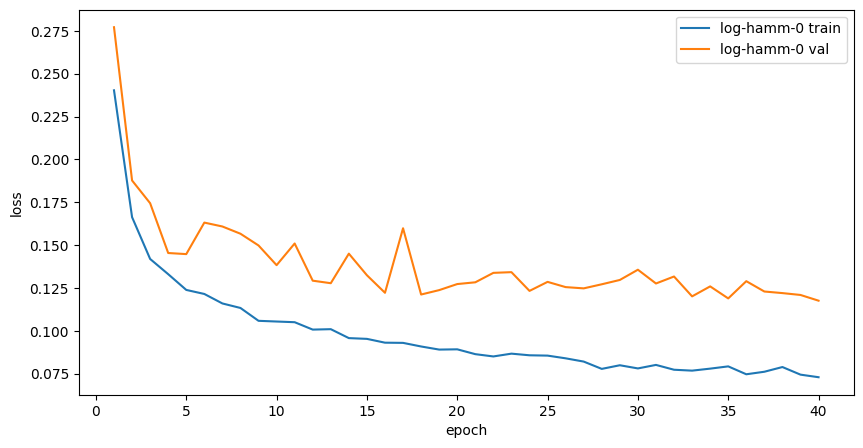

In [11]:
# Get path to folder containing logs 
log_folder = r'E:\baseline-w-normalization\logs-normalize0'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

### Mean 0.5, std dev 1

In [17]:
main_folder = r'E:\baseline-w-normalization'
spectro_file = main_folder + '\\' + 'spec_config_100-1200Hz-0.032-hamm-normalized0.5.json'
recipe_file = r'E:\final-baseline-detector\resnet_recipe-1.json'
pos_folder = r'E:\final-baseline-detector\annots\pos'
neg_folder = r'E:\final-baseline-detector\annots\neg'
file_durations_file = r'E:\final-baseline-detector\all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

db_name = main_folder + '\\' + 'final-baseline-db-normalized05.h5'
model_name = main_folder + '\\' + 'final-baseline-model-normalized05.kt'
temp_folder = main_folder + '\\' + 'rs-temp'

data_folder = r'D:\ringed-seal-data'

In [18]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:42<00:00, 39.21it/s]


6362 items saved to E:\baseline-w-normalization\final-baseline-db-normalized05.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:43<00:00, 41.40it/s]


1813 items saved to E:\baseline-w-normalization\final-baseline-db-normalized05.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:21<00:00, 42.31it/s]

894 items saved to E:\baseline-w-normalization\final-baseline-db-normalized05.h5


In [19]:
# Set the random seed for numpy and tensorflow 
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

# Set the log folder and checkpoint folder 
log_folder = main_folder + '\\' + 'logs-normalize05'
checkpoint_folder = main_folder + '\\' + 'checkpoints-normalize05'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively 
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/val/data")

# Create batches of training data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
resnet = ResNetInterface.build(recipe_file)

# Set the training and validation generators to the batch generators created above 
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory 
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# Train the model, looping through all of the training and validation data 
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=True, log_csv=True, csv_name='log-hamm-0.32-manual.csv')

# Close the database 
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model 
resnet.save(model_name, audio_repr_file=spectro_file)

print('Done')


Epoch: 1 
train_loss: 0.23876328766345978
train_CategoricalAccuracy: 0.801 train_Precision: 0.844 train_Recall: 0.738 
val_loss: 0.3119749426841736
val_CategoricalAccuracy: 0.685 val_Precision: 0.863 val_Recall: 0.439 


Epoch: 2 
train_loss: 0.16584822535514832
train_CategoricalAccuracy: 0.866 train_Precision: 0.879 train_Recall: 0.848 
val_loss: 0.2515544295310974
val_CategoricalAccuracy: 0.760 val_Precision: 0.894 val_Recall: 0.588 


Epoch: 3 
train_loss: 0.14173951745033264
train_CategoricalAccuracy: 0.889 train_Precision: 0.901 train_Recall: 0.873 
val_loss: 0.1690494418144226
val_CategoricalAccuracy: 0.863 val_Precision: 0.865 val_Recall: 0.859 


Epoch: 4 
train_loss: 0.1339392066001892
train_CategoricalAccuracy: 0.893 train_Precision: 0.902 train_Recall: 0.881 
val_loss: 0.17616716027259827
val_CategoricalAccuracy: 0.864 val_Precision: 0.903 val_Recall: 0.815 


Epoch: 5 
train_loss: 0.12437745183706284
train_CategoricalAccuracy: 0.902 train_Precision: 0.911 train_Recall: 0.8

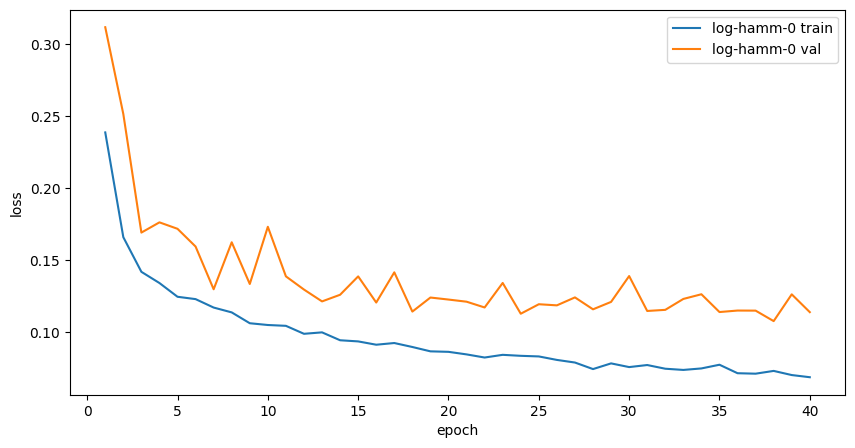

In [20]:
# Get path to folder containing logs 
log_folder = r'E:\baseline-w-normalization\logs-normalize05'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

### Adjust Range


In [16]:
main_folder = r'E:\baseline-w-normalization'
spectro_file = main_folder + '\\' + 'spec_config_100-1200Hz-0.032-hamm-adjustrange.json'
recipe_file = r'E:\final-baseline-detector\resnet_recipe-1.json'
pos_folder = r'E:\final-baseline-detector\annots\pos'
neg_folder = r'E:\final-baseline-detector\annots\neg'
file_durations_file = r'E:\final-baseline-detector\all_file_durations_complete.xlsx'
file_durations = pd.read_excel(file_durations_file)

db_name = main_folder + '\\' + 'final-baseline-db-adjustrange.h5'
model_name = main_folder + '\\' + 'final-baseline-model-adjustrange.kt'
temp_folder = main_folder + '\\' + 'rs-temp'

data_folder = r'D:\ringed-seal-data'

In [13]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 6362/6362 [02:47<00:00, 38.02it/s]


6362 items saved to E:\baseline-w-normalization\final-baseline-db-adjustrange.h5


100%|██████████████████████████████████████████████████████████████████████████████| 1813/1813 [00:43<00:00, 41.77it/s]


1813 items saved to E:\baseline-w-normalization\final-baseline-db-adjustrange.h5


100%|████████████████████████████████████████████████████████████████████████████████| 894/894 [00:21<00:00, 41.68it/s]

894 items saved to E:\baseline-w-normalization\final-baseline-db-adjustrange.h5


In [17]:
# Set the random seed for numpy and tensorflow 
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 40

# Set the log folder and checkpoint folder 
log_folder = main_folder + '\\' + 'logs-adjustrange'
checkpoint_folder = main_folder + '\\' + 'checkpoints-adjustrange'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively 
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/val/data")

# Create batches of training data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object 
resnet = ResNetInterface.build(recipe_file)

# Set the training and validation generators to the batch generators created above 
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory 
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# Train the model, looping through all of the training and validation data 
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=True, log_csv=True, csv_name='log-hamm-0.32-manual.csv')

# Close the database 
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model 
resnet.save(model_name, audio_repr_file=spectro_file)

print('Done')


Epoch: 1 
train_loss: 0.14174841344356537
train_CategoricalAccuracy: 0.877 train_Precision: 0.869 train_Recall: 0.887 
val_loss: 0.499467134475708
val_CategoricalAccuracy: 0.499 val_Precision: 0.499 val_Recall: 1.000 


Epoch: 2 
train_loss: 0.11605007946491241
train_CategoricalAccuracy: 0.898 train_Precision: 0.884 train_Recall: 0.915 
val_loss: 0.3602360785007477
val_CategoricalAccuracy: 0.621 val_Precision: 0.569 val_Recall: 0.999 


Epoch: 3 
train_loss: 0.10768035799264908
train_CategoricalAccuracy: 0.905 train_Precision: 0.893 train_Recall: 0.921 
val_loss: 0.12134651839733124
val_CategoricalAccuracy: 0.883 val_Precision: 0.897 val_Recall: 0.865 


Epoch: 4 
train_loss: 0.10472331941127777
train_CategoricalAccuracy: 0.909 train_Precision: 0.895 train_Recall: 0.927 
val_loss: 0.24348874390125275
val_CategoricalAccuracy: 0.800 val_Precision: 0.715 val_Recall: 0.996 


Epoch: 5 
train_loss: 0.10110797733068466
train_CategoricalAccuracy: 0.911 train_Precision: 0.900 train_Recall: 0.

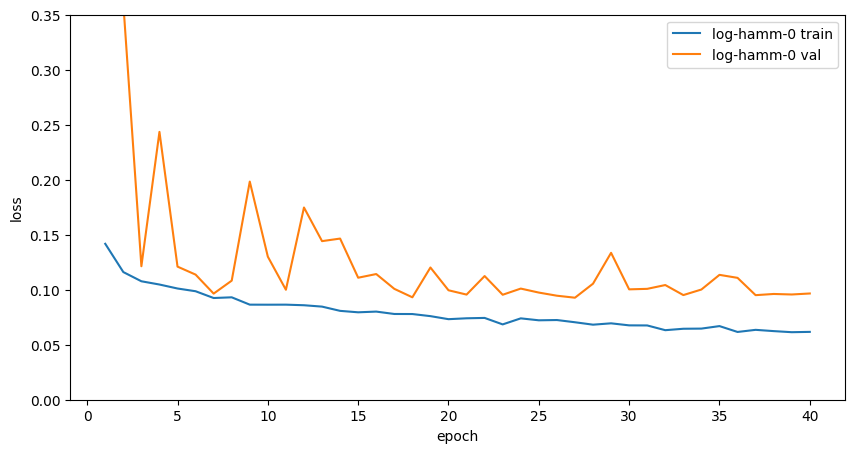

In [18]:
# Get path to folder containing logs 
log_folder = r'E:\baseline-w-normalization\logs-adjustrange'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
axes.set_ylim(0.0, 0.35)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

## Test Models

In [20]:
def compute_detections(labels, scores, threshold=0.5):

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

In [21]:
def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('Confusion Matrix')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

### Mean 0, Std dev 1

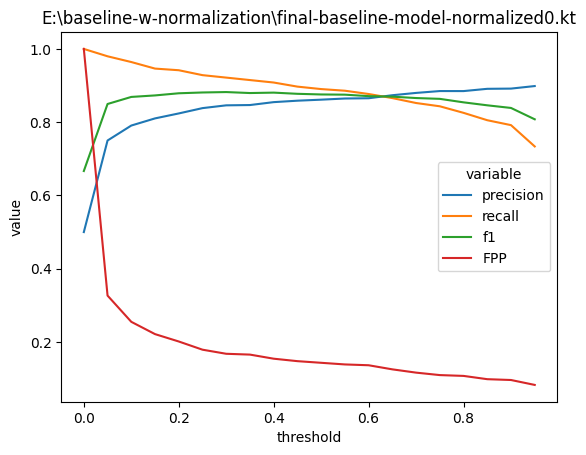

In [22]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-w-normalization\metrics-normalize0'
main_folder = r'E:\baseline-w-normalization'
db_name = main_folder + '\\' + 'final-baseline-db-normalized0.h5'
model_name = main_folder + '\\' + 'final-baseline-model-normalized0.kt'
temp_folder = main_folder + '\\' + 'temp-normalized0'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csv = "classifications.csv"
metric_csv = "metrics.csv"
stats_csv = "stats.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

Confusion Matrix


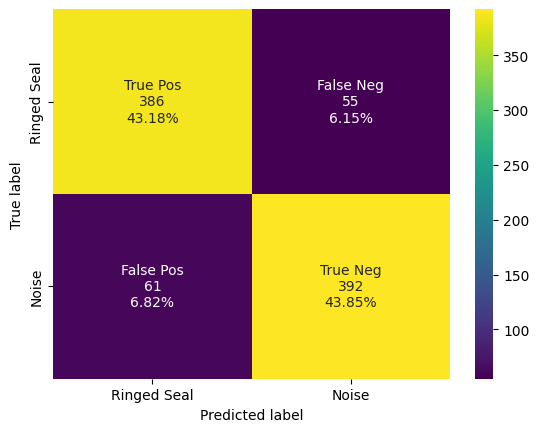

In [24]:
threshold = 0.6

classifications_file = r'E:\baseline-w-normalization\metrics-normalize0\classifications.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

### Mean 0.5, std dev 1

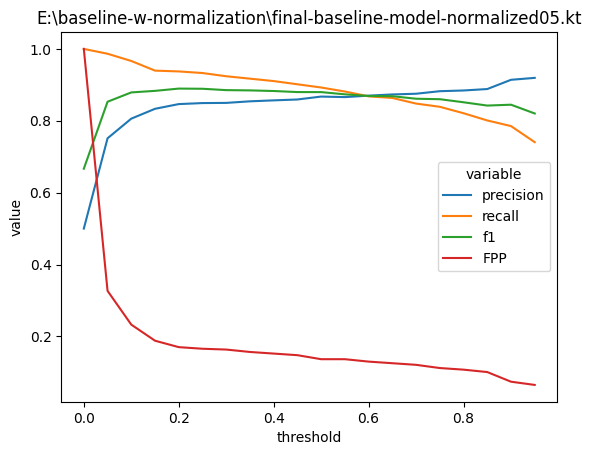

In [27]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-w-normalization\metrics-normalize05'
main_folder = r'E:\baseline-w-normalization'
db_name = main_folder + '\\' + 'final-baseline-db-normalized05.h5'
model_name = main_folder + '\\' + 'final-baseline-model-normalized05.kt'
temp_folder = main_folder + '\\' + 'temp-normalized05'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csv = "classifications.csv"
metric_csv = "metrics.csv"
stats_csv = "stats.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

Confusion Matrix


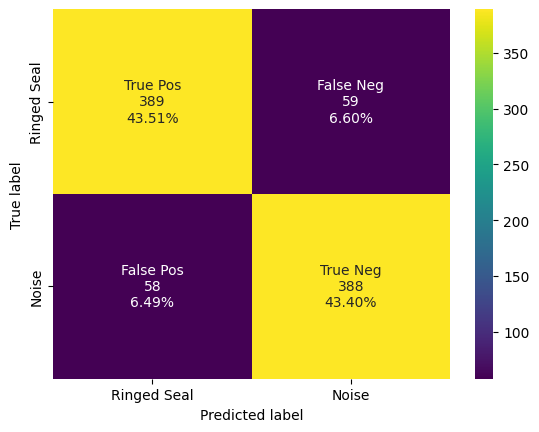

In [29]:
threshold = 0.6

classifications_file = r'E:\baseline-w-normalization\metrics-normalize05\classifications.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

### Adjust Range

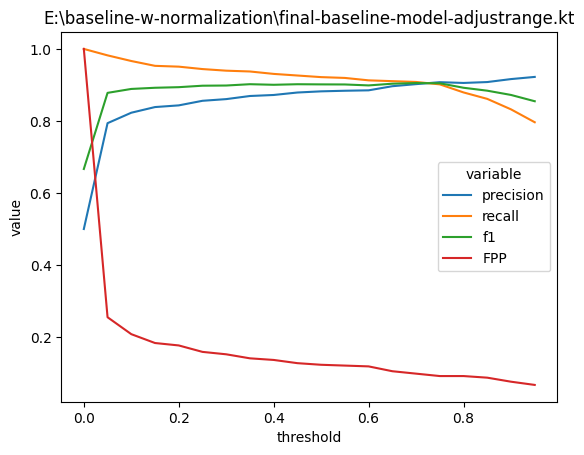

In [22]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-w-normalization\metrics-adjustrange'
main_folder = r'E:\baseline-w-normalization'
db_name = main_folder + '\\' + 'final-baseline-db-adjustrange.h5'
model_name = main_folder + '\\' + 'final-baseline-model-adjustrange.kt'
temp_folder = main_folder + '\\' + 'temp-adjustrange'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csv = "classifications.csv"
metric_csv = "metrics.csv"
stats_csv = "stats.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

Confusion Matrix


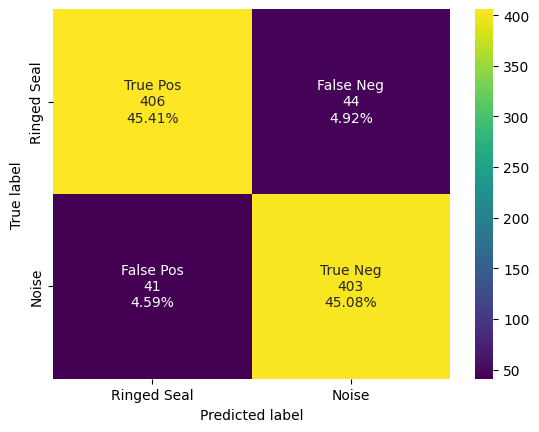

In [24]:
threshold = 0.75

classifications_file = r'E:\baseline-w-normalization\metrics-adjustrange\classifications.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')